In [1]:
import numpy as np
import scipy.signal as si
import matplotlib.pyplot as pl
from mezze.tfq import *
import cirq
from qiskit import Aer,execute
import qiskit as qk

# Introduction
This notebook takes a sample SchWARMA dephasing model and demonstrates 
1. How to perform simulation and PSD estimation (both non-negative least squares and parametric) using fixed total time pulse sequences (FTTPS)
2. How to leverage `cirq`'s capability to convert to QASM as a bridge to generate random circuits for gate-based noise injection on the IBM QE

Note that we use the qiskit simulator to demonstrate this, which will require some modification to use the actual cloud.  

## Part 1: `mezze` simulation

Here we generate an example $1/f^2$ noise model and verify its power spectrum

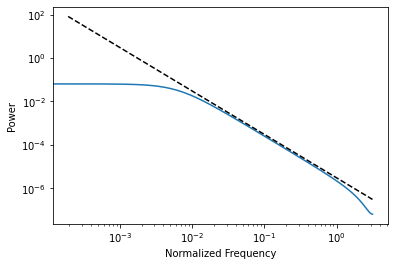

Total Power: 0.00020194829230730566


In [2]:
# First a mechanism for 1/f^\alpha noise

def get_pink_arma(alpha, power=None, wl=.001*np.pi, wh=.999*np.pi):
    """
    Implementes the approach from
    
         S. Plaszczynski, Fluctuation and Noise Letters7, R1 (2007)
     
    alpha: float between in (0,2] that determines the noise exponent
    power: float to normalize total power
    wl: float normalized frequency cut off for white band at start
    wh: float normalized frequency cut off for 1/f^2 band at end
    
    returns bb, aa np.array of ARMA coefficients (in si.filter form)
    
    """
    Nf = np.ceil(2.5*(np.log10(wh)-np.log10(wl)))
    delp = (np.log10(wh)-np.log10(wl))/Nf
    logps = np.log10(wl)+.5*(1-alpha/2.)*delp + np.arange(Nf)*delp
    logzs = logps+alpha/2.*delp
    ps = 10**(logps)
    zs = 10**(logzs)

    pstx = (1-ps)/(1+ps)
    zstx = (1-zs)/(1+zs)
    bb,aa = si.zpk2tf(zstx,pstx,k=1e-4)
    if power is not None:
        w_pa,h_pa = si.freqz(bb,aa,worN=2048*8, whole=True)
        acv = np.fft.ifft(np.abs(h_pa)**2)
        bb = bb/np.sqrt(acv[0])*np.sqrt(power)
    
    return bb, aa

bb, aa = get_pink_arma(2, power = 2e-4)

w_pa,h_pa = si.freqz(bb,aa,worN=2048*8, whole=False)

pl.figure()
pl.plot(w_pa, np.abs(h_pa)**2)
pl.plot(w_pa[1:], .3e-5/w_pa[1:]**2,'--k')
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Normalized Frequency')
pl.ylabel('Power')
pl.show()
print('Total Power: {0}'.format(2*np.sum(np.abs(h_pa)**2)*w_pa[1]/(2*np.pi)))

Next we generate the FTTPS sequences, as described in [arXiv:2010.04580](https://arxiv.org/abs/2010.04580) and  [arXiv:2102.03370](https://arxiv.org/abs/2102.03370), and generate the filter functions that we will use for both the parametric (fine frequency scale) and NNLS (course frequency scale) reconstructions.

In [3]:
# Get the FTTPS sequences and filter functions
num_FTTPS= 64

N = 2*num_FTTPS
worN = 8192

FTTPS_circuits = get_FTTS_circuits(N)


Phi, PhiRecon, num_gates = get_FTTS_FFs(N,worN)
Phi = Phi.astype(np.float32)
num_gates = num_gates.astype(np.float32)

The next few cells generate the SchWARMA model and simulates.

In [4]:
S = SimpleDephasingSchWARMAFier(bb, aa)

In [5]:
# This simulates 1000 short per sequence
sims  = [TensorFlowSchWARMASim(circ, S) for circ in FTTPS_circuits]
ps = [sim.output_sample(1000) for sim in sims]
ps = np.mean(ps,1)

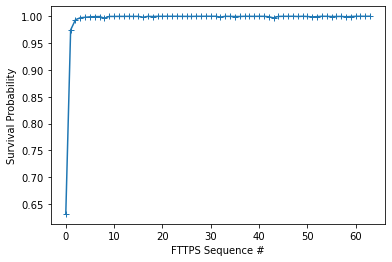

In [6]:
pl.figure()
pl.plot(ps,'-+')
pl.xlabel('FTTPS Sequence #')
pl.ylabel('Survival Probability')
pl.show()

Next we fit a model using the TensorFlow-based learner, and then use the built in methods to convert to power spectrum and get a NNLS estimate

In [7]:
learner = ZDephasingFFLearner(len(bb),len(aa))
learner.fit(ps, Phi, num_gates)

3.140456428241123e-08

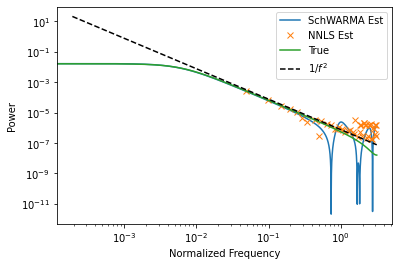

In [8]:
b_hat, a_hat = learner.convert_to_lfilter_form()
P_nnls = learner.NNLS_recon(ps, PhiRecon)
w_nnls, _ = si.freqz(b_hat,a_hat, worN=N//2, whole=False)
w, h_hat = si.freqz(b_hat,a_hat,worN = 2048*8, whole=False)


pl.figure()
pl.plot(w, np.abs(h_hat)**2,label='SchWARMA Est')
pl.plot(w_nnls, P_nnls,'x',label='NNLS Est')
pl.plot(w_pa, np.abs(h_pa)**2/4,label = 'True')
pl.plot(w_pa[1:], .075e-5/w_pa[1:]**2,'--k', label=r'$1/f^2$')
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Normalized Frequency')
pl.ylabel('Power')
pl.legend()
pl.show()

## Part 2: Repeat everything using the IBM simulation tools
Note that you will need the IBM qiskit software installed to actually run this, and we do not guarentee that it will be up to date with the newest API.  At best, use this as a template for how to convert from random cirq objects generated by mezze to plug into IBM. At some point in the future if IBM (or someone else) directly supports `cirq.Circuits`, this will basically be moot.

In [9]:
# Basically Repeat the above using qiskit. You'll have to adapt to actually run on the cloud.

device = 'qasm_simulator'
backend = Aer.get_backend(device)
num_schwarma_trajectories = 50
num_shots_per_trajectory = 2000

ps_IBM = np.zeros((len(FTTPS_circuits),1))

for circ_lcv, circ in enumerate(FTTPS_circuits):
    
    #need to explicitly add measurement gates
    for q in circ.all_qubits():
        circ.append(cirq.measure(q))
        
    noisy_circs = S.gen_noisy_circuit(circ, num_schwarma_trajectories)
    noisy_counts = {}
    for i, noisy_circ in enumerate(noisy_circs):

        cirq.circuits.QasmOutput(noisy_circ, noisy_circ.all_qubits()).save('qasm_tmp.qasm')    
        ibm_circ = qk.QuantumCircuit.from_qasm_file('qasm_tmp.qasm')

        job = execute(ibm_circ, backend, shots=num_shots_per_trajectory)
        result = job.result()
        counts = result.get_counts(ibm_circ)

        for key in counts:
            if key in noisy_counts:
                noisy_counts[key]+=counts[key]
            else:
                noisy_counts[key]=counts[key]
    ps_IBM[circ_lcv] = noisy_counts['0']/(num_schwarma_trajectories*num_shots_per_trajectory)

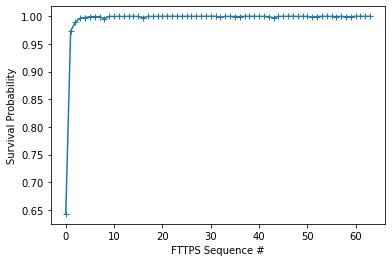

In [10]:
pl.figure()
pl.plot(ps_IBM,'-+')
pl.xlabel('FTTPS Sequence #')
pl.ylabel('Survival Probability')
pl.show()

In [11]:
learner_IBM = ZDephasingFFLearner(len(bb),len(aa))
learner_IBM.fit(ps_IBM, Phi, num_gates)

1.8114819511083624e-07

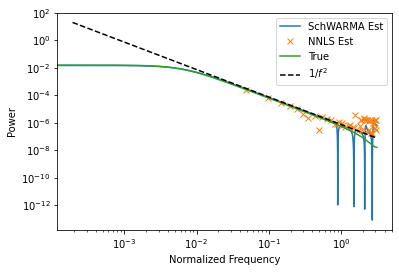

In [12]:
b_hat, a_hat = learner_IBM.convert_to_lfilter_form()
P_nnls = learner_IBM.NNLS_recon(ps, PhiRecon)
w_nnls, _ = si.freqz(b_hat,a_hat, worN=N//2, whole=False)
w, h_hat = si.freqz(b_hat,a_hat,worN = 2048*8, whole=False)


pl.figure()
pl.plot(w, np.abs(h_hat)**2,label='SchWARMA Est')
pl.plot(w_nnls, P_nnls,'x',label='NNLS Est')
pl.plot(w_pa, np.abs(h_pa)**2/4,label = 'True')
pl.plot(w_pa[1:], .075e-5/w_pa[1:]**2,'--k', label=r'$1/f^2$')
pl.xscale('log')
pl.yscale('log')
pl.xlabel('Normalized Frequency')
pl.ylabel('Power')
pl.legend()
pl.show()